In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC 

# for color map
import seaborn as sns

# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# import the formation channel scripts
from ClassFormationChannels_5mainchannels import * 
# import the comsic integration (SFRD) scripts
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data 


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Set the file and the DCOtype that you want to plot this figure for 

In [2]:
# enter path to hdf5 file that contains the data for your systems of interest, and the weights for detecting such sources. 
pathCOMPASOutput= '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_BHNS_A.h5'
fdata = h5.File(pathCOMPASOutput)

# print(fdata['doubleCompactObjects'].keys())

print(fdata.keys())
print(fdata['weights_detected'].keys())


# set settings for which DCO to plot 
OPTIMISTIC = False 
DCOtype = 'BHNS'

<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems', 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift']>
<KeysViewHDF5 ['SEED', 'w_000', 'w_111', 'w_112', 'w_113', 'w_121', 'w_122', 'w_123', 'w_131', 'w_132', 'w_133', 'w_211', 'w_212', 'w_213', 'w_221', 'w_222', 'w_223', 'w_231', 'w_232', 'w_233', 'w_311', 'w_312', 'w_313', 'w_321', 'w_322', 'w_323', 'w_331', 'w_332', 'w_333']>


# calculate the formation channels that the BH-NS form through. 

In [3]:
# obtain the seeds of the BHNS for each channel


seedsPercentageClassic, seedsPercentageOnlyStableMT = returnSeedsPercentageClassicAndOnlyStableMT(pathCOMPASOutput=pathCOMPASOutput,\
                                types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                binaryFraction=1)
seedsClassic, percentageClassic = seedsPercentageClassic
seedsOnlyStableMT, percentageOnlyStableMT = seedsPercentageOnlyStableMT



seedsDoubleCE, percentageDoubleCE = returnSeedsPercentageDoubleCoreCEE(pathCOMPASOutput=pathCOMPASOutput,\
                                types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                binaryFraction=1)


seedsSingleCE, percentageSingleCE = returnSeedsPercentageSingleCoreCEE(pathCOMPASOutput=pathCOMPASOutput,\
                                types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                binaryFraction=1)



seedschannels = [seedsClassic, seedsOnlyStableMT, seedsSingleCE, seedsDoubleCE]

seedsOther, percentageOther = returnSeedsPercentageOther(pathCOMPASOutput=pathCOMPASOutput,\
                                types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                binaryFraction=1, channelsSeedsList=seedschannels)




dictChannelsBHNS = { 'classic':seedsClassic, \
                    'immediate CE':seedsSingleCE,\
                         'stable B no CEE':seedsOnlyStableMT, \
                     r'double-core CE':seedsDoubleCE,  \
                        'other':seedsOther\
                       }


dictPercentages = { 'classic':percentageClassic, \
                    'immediate CE':percentageSingleCE,\
                         'stable B no CEE':percentageOnlyStableMT, \
                     r'double-core CE':percentageDoubleCE,  \
                        'other':percentageOther\
                       } 

weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[maskInterest]


percentage Classic        =  65.18201235140664
percentage Only stable MT =   5.081141190979925
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage double core CE channel = 3.36936747652693
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:534: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage single core CE channel = 19.67088471620494
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()
percentage other channel =  6.696594264881554


## main plotting function: 

In [4]:
def plotdesigndistribution(axe, weights, DCOseeds, xvar, bandwidth, xvarrange, xlabel, ylabel, xlim, ylim, indplot):
    """ plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    whichWeight = 'intrinsic' 'observed'
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """
    dictList=dictChannelsBHNSList

    axes = [axe]

    
    
    # MAKE MAIN DISTRIBUTION PLOT
    res_kde =1000 # resolution kde, just the nr of interpolation points (so this is not the bandwith). 
    # if a range for the kde is given, use that, otherwise use min & max of the variable. 
    # you want to give a range if the kde has large values at the edge of the xvar ranges (e.g. for mass ratio)
    if xvarrange:
        binsM = np.linspace(xvarrange[0], xvarrange[1], res_kde)
    else:
        binsM =np.linspace(min(xvar)*0.9, 1.1*max(xvar), res_kde)
    dM    = np.diff(binsM)
    M     = (binsM[1:]+binsM[:-1])/2.

    

    # this will count the totalweight across the kde. 
    totalweight = 0


    
    xx_boot = np.linspace(min(xvar)*0.8,max(xvar)*1.2, 100)
    yLow        = np.zeros(len(xx_boot))

    for nrC, Channel in enumerate(dictList):
    
    #   #Get the seeds that relate to sorted indices
        seedsInterest = dictRank[Channel] 
        maskSeedsInterest = np.in1d(DCOseeds, seedsInterest)
    
        
        # only if the channel group is present do plotting:
        if len(xvar[maskSeedsInterest]):
            m       = xvar[maskSeedsInterest]
            w       = weights[maskSeedsInterest]
            percentage = np.round((np.sum(w)/float(np.sum(weights)))*100,6)
            y, _    = np.histogram(m, bins=binsM, weights=w)
            y       = np.divide(y, dM)

            # remake histogram
            totalweight += np.sum(w)
            totalweight_nrG = np.sum(w)
            ##

            KDE = gaussian_kde(m, weights=w, bw_method = bandwidth)
            y_boot = KDE(xx_boot)


            ##
            if indplot==0:
                percentage_label = roundAndFormat1(percentage)
                if percentage_label==str(0):
                    percentage_ = '<1'
                else: 
                    percentage_=percentage_label
                LABEL = dictChannelsBHNSListBolt[nrC] + ' '+r'$%s$'%(percentage_) + str(r'\%')
            else:
                LABEL = None


            axe.fill_between(xx_boot, yLow, yLow+(y_boot*totalweight_nrG), facecolor=colorlist[nrC], \
                             alpha=1, label=LABEL, zorder=200)
            yLow   +=y_boot*totalweight_nrG
    
 
    axe.plot(xx_boot,  (yLow), color='k', linewidth=5, zorder=200)
    
    

    
    
    ### PLOT CDF on right axes ###
    ax2y = axe.twinx()
    # label / tick settings
    cdfcolor = 'red'
    ylabel2 = 'CDF'

    ax2y.set_ylim(0,1)
    ax2y.tick_params(labelsize=fs, colors=cdfcolor)
    ax2y.set_ylabel(ylabel2, fontsize=fs, color=cdfcolor)       
    
    # plot cdf:
    ax2y.hist(xvar, density=True, bins=len(xvar), cumulative=True, label=None,
         histtype='step', alpha=1, color=cdfcolor, linewidth=3, linestyle='-.', zorder=30, weights=weights)    


    ###############################    
    # MAKE CDF background
    y_quantiles = np.linspace(0,1,11)
    x_quantiles = weighted_quantile(values=xvar, quantiles=y_quantiles, \
                       sample_weight=weights)

    xx0 = x_quantiles[0] # start of cdf = 0%
    # COLOR MAP 
    cm       = plt.get_cmap('Greys')
    Nc = len(x_quantiles)
    greys = [cm(x) for x in np.linspace(0,1 , int(1.5*Nc))]  # I dont want the dark colors
    greysFlip = [cm(x) for x in np.flip(np.linspace(0,1 , int(1.5*Nc)))]  # flip the grey list for text colors
    
    

    
    for ind_q, xquant in enumerate(x_quantiles[1:]): # skip 0 
        if ind_q==len(x_quantiles[1:])-1:
            xx = np.linspace(xx0, xlim[1], 10)
        else:
            xx = np.linspace(xx0, xquant, 10)
            textt_q = str(int(y_quantiles[ind_q+1]*100))  +'\%'

            axe.text(xquant, 0.98*ylim[1], s=textt_q, rotation = 90, \
                     fontsize = fs-10, color ='k', ha = 'right', va='top')#, weight = 'bold')

        axe.fill_between(xx, np.zeros_like(xx), np.ones_like(xx)*ylim[1]*1.1, facecolor=greys[ind_q+1], \
                         alpha=1, zorder=1)#,\ 


        xx0 = xquant     
    
    # end of CDF background making block 
    ################################
    
    
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

    axe == layoutAxes(axe, nameX=xlabel, nameY=ylabel)

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
    
    
    return handles, labels
    

# The next block of code makes the figure using the code above

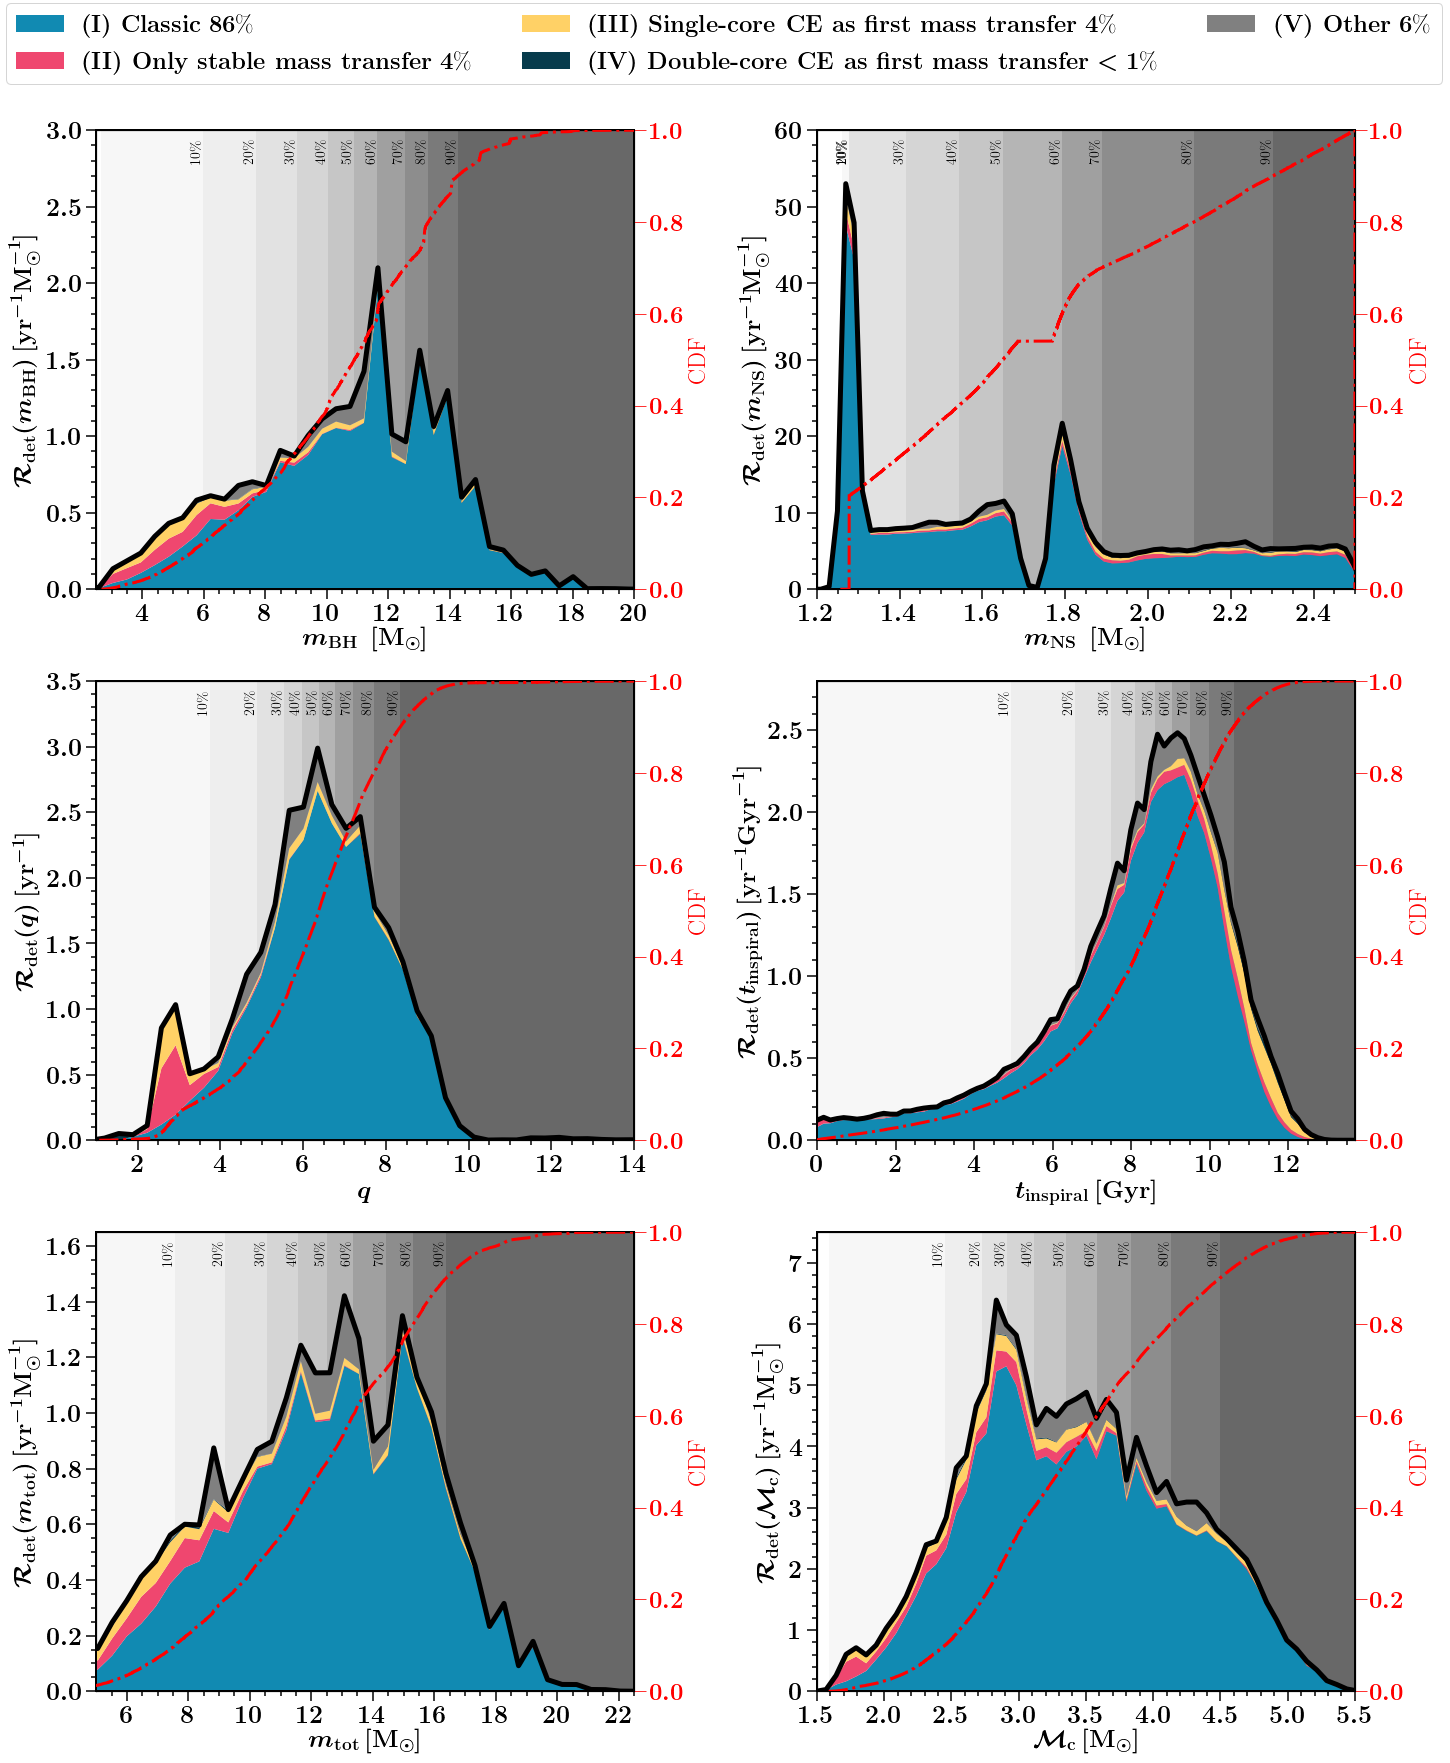

In [5]:





## settings for plotting figure 
linewidth=3.5
ALPHA=0
Nbins=0.04

dictRank=dictChannelsBHNS





# enter which weights you want to plot, and the name you want to give your plot for these weights
name_weights ='detected_000'
# the weights can be found in the sepearte data files. 
# these are the weight files that are in the hdf5 files: 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift'
# weights_detected, contains the LIGO/Virgo/KAGRA detectable rates for all 28 SFRD models. 
# we choose in this example the weights for the fiducial model xyz=000
weights     = fdata['weights_detected']['w_000'][...].squeeze()




##############################################
##############################################
f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})

## Obtain BH and NS mass
M1, M2 = fdata['doubleCompactObjects']['M1'][...].squeeze(), fdata['doubleCompactObjects']['M2'][...].squeeze()
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)


DCOseeds = fdata['doubleCompactObjects']['seed'][...].squeeze()
seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
# get only SN seeds for DCOs 
maskSNdco = np.in1d(seedsSN,  DCOseeds) 
whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
whichSN1 = whichSN[::2] # get whichStar for first SN 


separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
separationPreSN2 = separationPreSN[1::2] # in Rsun. 
maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) ) 




ii=0
rate_disrupted = np.zeros(6)
allweight = np.sum(weights, axis=0)
labelMej = []
for ind_chi, chi in enumerate([0.0, .5, 'Qin']):
    if chi=='Qin':
        # Qin 2018 spin model 
        BH_chi = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
    else:    
        BH_chi   = chi * np.ones_like(MNS)

    for ind_Rns, NSradii in enumerate([11.5,13.0]):
        Rns = NSradii
        NS_radii = Rns * np.ones_like(MNS)

        Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

        maskEjecta = (Mej > 0)
        combinedweight = np.sum(weights[maskEjecta])
        
        rate_disrupted[ii]+= np.sum(combinedweight) / np.sum(allweight)
        labelMej.append('chi = ' + str(chi) + ' Rns = ' + str(NSradii) +' km')
        ii+=1




######### BH MASS 
xvar = MBH
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{BH}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r' $m_{\rm{BH}}$ $ \,  [\rm{M}_{\odot}]$'

handles, labels=plotdesigndistribution(axe=ax[0,0], weights=weights, DCOseeds=DCOseeds, xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                              xlim=[2.5,20], ylim=[0,3],   indplot=0) 


####### NS MASS 
xvar = MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{NS}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{NS}}$   $ \,  [\rm{M}_{\odot}]$ '

_,_=plotdesigndistribution(axe=ax[0,1], weights=weights, DCOseeds=DCOseeds, xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                              xlim=[1.2,2.5], ylim=[0,60],   indplot=1) 




####### mass ratio
xvar = MBH/MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(q) \, [\rm{yr}^{-1}]  $'
nameX = r'$q$'

_,_=plotdesigndistribution(axe=ax[1,0], weights=weights, DCOseeds=DCOseeds, xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                              xlim=[1,14], ylim=[0,3.5],   indplot=2) 



######## INSPIRAL TIME
xvar = fdata['doubleCompactObjects']['tc'][...].squeeze() / 1000
nameY = r'$ \mathcal{R}_{\rm{det}}(t_{\rm{inspiral}}) \, [\rm{yr}^{-1}  \rm{Gyr}^{-1}]  $'
nameX = r'$t_{\rm{inspiral}} \, [\rm{Gyr}]$'

_,_=plotdesigndistribution(axe=ax[1,1], weights=weights, DCOseeds=DCOseeds, xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                              xlim=[0,13.7], ylim=[0,2.8],   indplot=3) 




####### mass total
xvar = MBH+MNS
nameY = r'$ \mathcal{R}_{\rm{det}}(m_{\rm{tot}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$m_{\rm{tot}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistribution(axe=ax[2,0], weights=weights, DCOseeds=DCOseeds, xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                              xlim=[5,22.5], ylim=[0,1.65],   indplot=4) 



####### mass chirp
xvar = chirpmass(MBH, MNS)
nameY = r'$ \mathcal{R}_{\rm{det}}(\mathcal{M}_{\rm{c}}) \, [\rm{yr}^{-1}  \rm{M}_{\odot}^{-1}]  $'
nameX = r'$\mathcal{M}_{\rm{c}} \,  [\rm{M}_{\odot}]$'

_,_=plotdesigndistribution(axe=ax[2,1], weights=weights, DCOseeds=DCOseeds, xvar=xvar, bandwidth=Nbins, xvarrange=None,xlabel=nameX, ylabel=nameY, \
                              xlim=[1.5,5.5], ylim=[0,7.5],   indplot=5) 

# ###########


# LEGEND
lgd = f.legend(handles, labels, fontsize=fs, ncol=3,\
         bbox_to_anchor=(1.01, 1.07),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2) # makes sure there is enough white speace between graphs 
plt.savefig('./DistributionsFiducialchannels_' + name_weights + '_' + DCOtype +'.pdf',  transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('./DistributionsFiducialchannels_' + name_weights + '_' + DCOtype +'.png',  transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()





# Table 4: BHNS that disrupt the NS outside of the BH ISCO


these percentages are calculated in the code above, here we just print it. 

In [6]:
for ii in range(6):
    print(labelMej[ii], 'NS disrupted fraction (out of 1):', rate_disrupted[ii])
    print(rate_disrupted[ii]*100, '%')
    print()

chi = 0.0 Rns = 11.5 km NS disrupted fraction (out of 1): 0.01321420022852315
1.321420022852315 %

chi = 0.0 Rns = 13.0 km NS disrupted fraction (out of 1): 0.042645589623534985
4.264558962353498 %

chi = 0.5 Rns = 11.5 km NS disrupted fraction (out of 1): 0.12623414086156767
12.623414086156767 %

chi = 0.5 Rns = 13.0 km NS disrupted fraction (out of 1): 0.2785700276237601
27.85700276237601 %

chi = Qin Rns = 11.5 km NS disrupted fraction (out of 1): 0.015094460417399595
1.5094460417399596 %

chi = Qin Rns = 13.0 km NS disrupted fraction (out of 1): 0.044837919443825175
4.483791944382517 %

